In [37]:
import sys
sys.version

'3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]'

In [38]:
!pip install -q mediapipe


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import urllib.request

url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task"
outfile = "pose_landmarker.task"

urllib.request.urlretrieve(url, outfile)

print("Downloaded:", outfile)

Downloaded: pose_landmarker.task


In [40]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

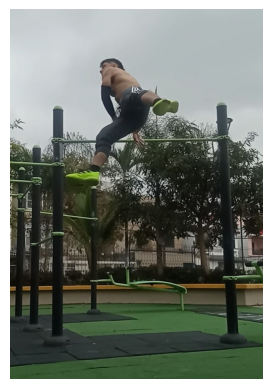

In [41]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("Swing7202.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB for proper colors

plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()

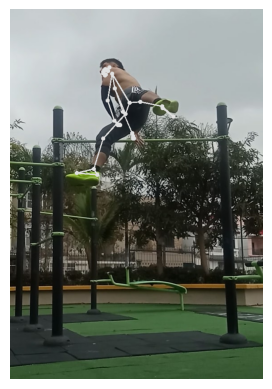

In [42]:
# STEP 0: Imports
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
from matplotlib import pyplot as plt

# Helper: display RGB image in Jupyter
def show_image(img_rgb):
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Helper: draw PoseLandmarkerResult on an RGB image
def draw_landmarks_on_image(rgb_image, detection_result):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    annotated_image = rgb_image.copy()

    # detection_result.pose_landmarks is a list of lists, not a proto
    for pose_landmarks in detection_result.pose_landmarks:
        # Convert list -> NormalizedLandmarkList proto
        landmark_list = landmark_pb2.NormalizedLandmarkList()
        landmark_list.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=l.x,
                    y=l.y,
                    z=l.z,
                    visibility=l.visibility,
                )
                for l in pose_landmarks
            ]
        )

        mp_drawing.draw_landmarks(
            annotated_image,
            landmark_list,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(
                thickness=2,
                circle_radius=2
            ),
            connection_drawing_spec=mp_drawing.DrawingSpec(
                thickness=2
            ),
        )

    return annotated_image

# STEP 1: Create PoseLandmarker
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 2: Load image (must be in the same folder as this notebook)
image = mp.Image.create_from_file("Swing7202.jpg")

# STEP 3: Run detection
detection_result = detector.detect(image)

# STEP 4: Draw landmarks and show
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
show_image(annotated_image)
